In [1]:
import torch
from IPython.display import Image  # for displaying images
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [2]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()

    # Initialise the info dict
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name
        if elem.tag == "filename":
            info_dict['filename'] = elem.text

        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict['image_size'] = tuple(image_size)

        # Get details of the bounding box
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict['bboxes'].append(bbox)

    return info_dict


In [5]:
testing = extract_info_from_xml('/home/venom/repo/yolo_dish/Dish-20/labels/03.xml')

In [6]:
testing

{'bboxes': [{'class': 'Fish-dish',
   'xmin': 122,
   'ymin': 81,
   'xmax': 327,
   'ymax': 356},
  {'class': 'Towel-dish', 'xmin': 362, 'ymin': 301, 'xmax': 503, 'ymax': 428},
  {'class': 'Rice-bowl', 'xmin': 41, 'ymin': 221, 'xmax': 169, 'ymax': 341},
  {'class': 'Rice-bowl', 'xmin': 123, 'ymin': 314, 'xmax': 247, 'ymax': 437},
  {'class': 'Chopsticks-two', 'xmin': 17, 'ymin': 93, 'xmax': 77, 'ymax': 287},
  {'class': 'Chopsticks-two',
   'xmin': 389,
   'ymin': 2,
   'xmax': 552,
   'ymax': 155},
  {'class': 'Wine-cup', 'xmin': 305, 'ymin': 187, 'xmax': 380, 'ymax': 262},
  {'class': 'Wine-cup', 'xmin': 503, 'ymin': 254, 'xmax': 599, 'ymax': 331},
  {'class': 'Cup', 'xmin': 431, 'ymin': 155, 'xmax': 535, 'ymax': 257},
  {'class': 'Cup', 'xmin': 271, 'ymin': 344, 'xmax': 370, 'ymax': 439},
  {'class': 'Cup', 'xmin': 411, 'ymin': 23, 'xmax': 515, 'ymax': 125},
  {'class': 'Spoon', 'xmin': 121, 'ymin': 38, 'xmax': 313, 'ymax': 118},
  {'class': 'Tea-cup', 'xmin': 248, 'ymin': 2, 'xmax

In [7]:
len(testing['bboxes'])

18

In [8]:
# Go through list of dictionaries, and create a set of clsses
classes = set()

# go through the folder of XML files, and extract the classes
for file in os.listdir('./Dish-20/labels'):
    for i in range(len(extract_info_from_xml('./Dish-20/labels/' + file)['bboxes'])):
        classes.add(extract_info_from_xml('./Dish-20/labels/' + file)['bboxes'][i]['class'])
    

In [9]:
len(classes)

20

In [10]:
# Sort the set, convert to list, then make classname to index dictionary
classes = list(classes)
classes.sort()
class_name_to_id_mapping = {classes[i]: i for i in range(len(classes))}


In [12]:
class_name_to_id_mapping.keys()

dict_keys(['Chopsticks-cover', 'Chopsticks-one', 'Chopsticks-two', 'Coffee', 'Coffee-cup', 'Coffee-dish', 'Cup', 'Fish-dish', 'Paper', 'Rice-bowl', 'Soup-bowl', 'Spoon', 'Square-bowl', 'Tea-cup', 'Tea-dish', 'Towel', 'Towel-dish', 'Waster-paper', 'Water-cup', 'Wine-cup'])

In [10]:
# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        print(b)
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

In [31]:
class_id_to_name_mapping = dict(
    zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))


def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:, [1, 3]] = annotations[:, [1, 3]] * w
    transformed_annotations[:, [2, 4]] = annotations[:, [2, 4]] * h

    transformed_annotations[:, 1] = transformed_annotations[:,1] - (transformed_annotations[:, 3] / 2)
    transformed_annotations[:, 2] = transformed_annotations[:,2] - (transformed_annotations[:, 4] / 2)
    transformed_annotations[:, 3] = transformed_annotations[:,1] + transformed_annotations[:, 3]
    transformed_annotations[:, 4] = transformed_annotations[:,2] + transformed_annotations[:, 4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0, y0), (x1, y1)))

        plotted_image.text(
            (x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])

    plt.imshow(np.array(image))
    plt.show()


In [32]:
# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

In [33]:
#Get the corresponding image file
image_file = annotation_file.replace(
    "annotations", "images").replace("txt", "jpg")


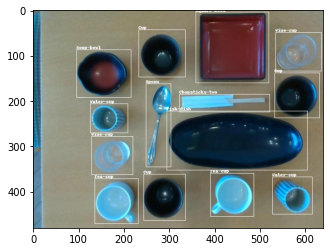

In [34]:
#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)


In [46]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
# Get annotation file names based on image file names
annotations = [x.replace("images", "annotations").replace(
    "jpg", "txt") for x in images]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)



In [53]:
# Verify if all images have annotations
for index, (train_image, train_annotation) in enumerate(zip(train_images, train_annotations)):
    if train_image.replace("images", "annotations").replace("jpg", "txt") != train_annotation:
        print("Mismatch at index : ", index)
        break

In [57]:
%cd /home/venom/repo/yolo_dish/

/home/venom/repo/yolo_dish


In [58]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [59]:
#Utility function to move images
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)


# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')
!mv annotations labels
%cd ../


/home/venom/repo
